# 1. Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# DL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans


2025-08-20 12:44:25.475590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755693865.679584      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755693865.742408      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['scaler.pkl']

# 2. Chargement et préparation des données

In [2]:
df = pd.read_csv("/kaggle/input/defaut-electrique/classData.csv")

# Créer un label combiné à partir de G, C, B, A
df['fault_type'] = df[['G','C','B','A']].astype(str).agg(''.join, axis=1)
unique_faults = df['fault_type'].unique()
fault_map = {ftype:i for i, ftype in enumerate(unique_faults)}
df['fault_class'] = df['fault_type'].map(fault_map)

# Features et labels
X = df[['Ia','Ib','Ic','Va','Vb','Vc']].values
y = df['fault_class'].values

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [3]:
df

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,fault_type,fault_class
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001,0
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001,0
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001,0
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001,0
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0000,5
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0000,5
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0000,5
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0000,5


# 3. MODELES

In [4]:
# --- Deep Learning : Autoencodeur ---
input_dim = X_train.shape[1]
encoding_dim = 3
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# entraînement
autoencoder.fit(X_train, X_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# sauvegarde
autoencoder.save("autoencoder_model.h5")

# reconstruction erreur
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)
threshold = np.percentile(reconstruction_error, 95)
y_pred_auto = (reconstruction_error > threshold).astype(int)  # 0 normal, 1 défaut

print("\n=== Autoencoder Report ===")
print(classification_report((y_test != 0).astype(int), y_pred_auto))
print("Confusion Matrix:\n", confusion_matrix((y_test != 0).astype(int), y_pred_auto))
print("Accuracy:", accuracy_score((y_test != 0).astype(int), y_pred_auto))

# --- KNN ---
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
joblib.dump(knn, "knn_model.pkl")

y_pred_knn = knn.predict(X_test)
print("\n=== KNN Report ===")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

# --- Naive Bayes ---
nb = GaussianNB()
nb.fit(X_train, y_train)
joblib.dump(nb, "naive_bayes_model.pkl")

y_pred_nb = nb.predict(X_test)
print("\n=== Naive Bayes Report ===")
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

# --- Logistic Regression ---
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
joblib.dump(lr, "logistic_regression_model.pkl")

y_pred_lr = lr.predict(X_test)
print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# --- Decision Tree ---
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
joblib.dump(dt, "decision_tree_model.pkl")

y_pred_dt = dt.predict(X_test)
print("\n=== Decision Tree Report ===")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
joblib.dump(rf, "random_forest_model.pkl")

y_pred_rf = rf.predict(X_test)
print("\n=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# --- SVM ---
svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)
joblib.dump(svc, "svc_model.pkl")

y_pred_svc = svc.predict(X_test)
print("\n=== SVC Report ===")
print(classification_report(y_test, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))
print("Accuracy:", accuracy_score(y_test, y_pred_svc))

# --- KMeans (Clustering non supervisé) ---
kmeans = KMeans(n_clusters=len(unique_faults), random_state=42)
kmeans.fit(X_train)
joblib.dump(kmeans, "kmeans_model.pkl")

y_pred_kmeans = kmeans.predict(X_test)
print("\n=== KMeans Report ===")
print(classification_report(y_test, y_pred_kmeans))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_kmeans))
print("Accuracy:", accuracy_score(y_test, y_pred_kmeans))


I0000 00:00:1755693919.072224      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755693919.072918      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1755693921.178007     111 service.cc:148] XLA service 0x789b84007680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755693921.178549     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755693921.178576     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755693921.353701     111 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755693921.945678     111 device_compiler.h:188] Compiled clust

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== Autoencoder Report ===
              precision    recall  f1-score   support

           0       0.15      1.00      0.26       226
           1       1.00      0.06      0.11      1347

    accuracy                           0.19      1573
   macro avg       0.58      0.53      0.19      1573
weighted avg       0.88      0.19      0.13      1573

Confusion Matrix:
 [[ 226    0]
 [1268   79]]
Accuracy: 0.19389701207883026

=== KNN Report ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       226
           1       0.98      0.97      0.97       227
           2       1.00      1.00      1.00       201
           3       0.28      0.28      0.28       219
           4       0.30      0.30      0.30       227
           5       1.00      1.00      1.00       473

    accuracy                           0.79      1573
   macro avg       0.75      0.76      0.76      1573
weighted avg       0.7

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Random Forest Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       1.00      1.00      1.00       227
           2       1.00      1.00      1.00       201
           3       0.54      0.55      0.55       219
           4       0.56      0.55      0.56       227
           5       1.00      1.00      1.00       473

    accuracy                           0.87      1573
   macro avg       0.85      0.85      0.85      1573
weighted avg       0.87      0.87      0.87      1573

Confusion Matrix:
 [[226   0   0   0   0   0]
 [  0 227   0   0   0   0]
 [  0   0 201   0   0   0]
 [  0   0   0 121  98   0]
 [  0   0   0 102 125   0]
 [  0   0   0   0   0 473]]
Accuracy: 0.8728544183089637

=== SVC Report ===
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       226
           1       0.93      0.95      0.94       227
           2       1.00      0.85

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# 4. Comparaison des modèles

In [16]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# =======================
# Comparaison des modèles
# =======================
results = []

# --- Autoencoder ---
acc_auto = accuracy_score((y_test != 0).astype(int), y_pred_auto)
f1_auto = f1_score((y_test != 0).astype(int), y_pred_auto, average="weighted")
results.append(["Autoencoder", acc_auto, f1_auto])

# --- KNN ---
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average="weighted")
results.append(["KNN", acc_knn, f1_knn])

# --- Naive Bayes ---
acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
results.append(["Naive Bayes", acc_nb, f1_nb])

# --- Logistic Regression ---
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
results.append(["Logistic Regression", acc_lr, f1_lr])

# --- Decision Tree ---
acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
results.append(["Decision Tree", acc_dt, f1_dt])

# --- Random Forest ---
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
results.append(["Random Forest", acc_rf, f1_rf])

# --- SVM ---
acc_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc, average="weighted")
results.append(["SVM", acc_svc, f1_svc])

# --- KMeans ---
acc_kmeans = accuracy_score(y_test, y_pred_kmeans)
f1_kmeans = f1_score(y_test, y_pred_kmeans, average="weighted")
results.append(["KMeans", acc_kmeans, f1_kmeans])

# =======================
# Tableau comparatif
# =======================
df_results = pd.DataFrame(results, columns=["Modèle", "Accuracy", "F1-Score"])
print("\n=== Résultats comparatifs ===")
print(df_results)

# =======================
# Sélection du meilleur modèle
# =======================
best_model = df_results.sort_values(by="F1-Score", ascending=False).iloc[0]
print("\n>>> Meilleur modèle :", best_model["Modèle"], 
      " (Accuracy:", round(best_model["Accuracy"], 4), 
      ", F1:", round(best_model["F1-Score"], 4), ")")



=== Résultats comparatifs ===
                Modèle  Accuracy  F1-Score
0          Autoencoder  0.193897  0.132637
1                  KNN  0.793388  0.792059
2          Naive Bayes  0.804832  0.765344
3  Logistic Regression  0.343293  0.218531
4        Decision Tree  0.883662  0.883663
5        Random Forest  0.872854  0.872865
6                  SVM  0.806739  0.804023
7               KMeans  0.095359  0.075887

>>> Meilleur modèle : Decision Tree  (Accuracy: 0.8837 , F1: 0.8837 )


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matrice de confusion - {title}")
    plt.xlabel("Prédictions")
    plt.ylabel("Réelles")
    plt.show()
    print(f"\nClassification Report - {title}:\n", classification_report(y_true, y_pred))


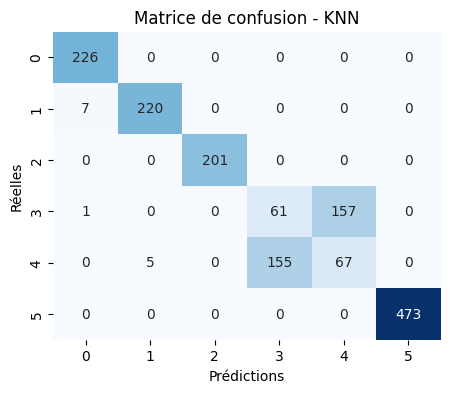


Classification Report - KNN:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       226
           1       0.98      0.97      0.97       227
           2       1.00      1.00      1.00       201
           3       0.28      0.28      0.28       219
           4       0.30      0.30      0.30       227
           5       1.00      1.00      1.00       473

    accuracy                           0.79      1573
   macro avg       0.75      0.76      0.76      1573
weighted avg       0.79      0.79      0.79      1573



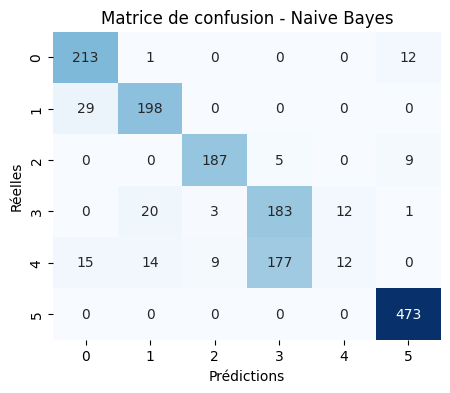


Classification Report - Naive Bayes:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88       226
           1       0.85      0.87      0.86       227
           2       0.94      0.93      0.93       201
           3       0.50      0.84      0.63       219
           4       0.50      0.05      0.10       227
           5       0.96      1.00      0.98       473

    accuracy                           0.80      1573
   macro avg       0.76      0.77      0.73      1573
weighted avg       0.79      0.80      0.77      1573



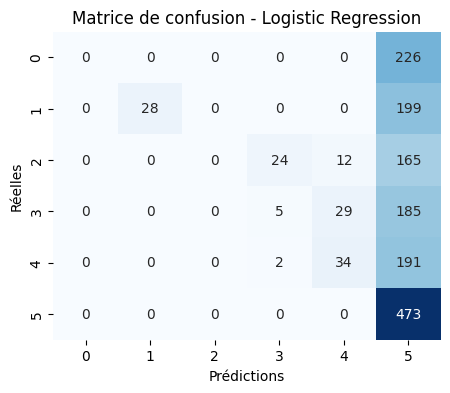


Classification Report - Logistic Regression:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       1.00      0.12      0.22       227
           2       0.00      0.00      0.00       201
           3       0.16      0.02      0.04       219
           4       0.45      0.15      0.23       227
           5       0.33      1.00      0.49       473

    accuracy                           0.34      1573
   macro avg       0.32      0.22      0.16      1573
weighted avg       0.33      0.34      0.22      1573



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


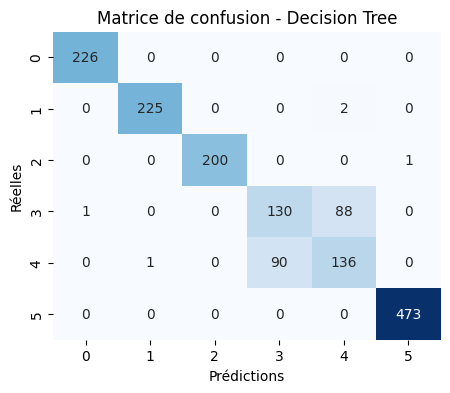


Classification Report - Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       1.00      0.99      0.99       227
           2       1.00      1.00      1.00       201
           3       0.59      0.59      0.59       219
           4       0.60      0.60      0.60       227
           5       1.00      1.00      1.00       473

    accuracy                           0.88      1573
   macro avg       0.86      0.86      0.86      1573
weighted avg       0.88      0.88      0.88      1573



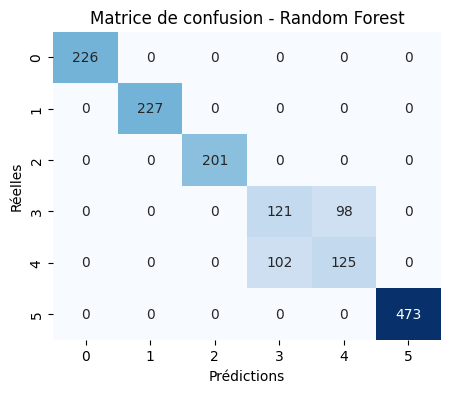


Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       1.00      1.00      1.00       227
           2       1.00      1.00      1.00       201
           3       0.54      0.55      0.55       219
           4       0.56      0.55      0.56       227
           5       1.00      1.00      1.00       473

    accuracy                           0.87      1573
   macro avg       0.85      0.85      0.85      1573
weighted avg       0.87      0.87      0.87      1573



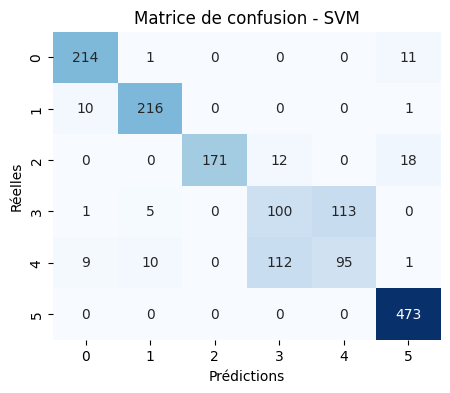


Classification Report - SVM:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       226
           1       0.93      0.95      0.94       227
           2       1.00      0.85      0.92       201
           3       0.45      0.46      0.45       219
           4       0.46      0.42      0.44       227
           5       0.94      1.00      0.97       473

    accuracy                           0.81      1573
   macro avg       0.78      0.77      0.77      1573
weighted avg       0.80      0.81      0.80      1573



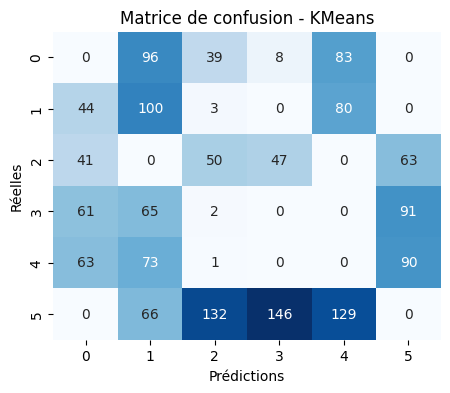


Classification Report - KMeans:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.25      0.44      0.32       227
           2       0.22      0.25      0.23       201
           3       0.00      0.00      0.00       219
           4       0.00      0.00      0.00       227
           5       0.00      0.00      0.00       473

    accuracy                           0.10      1573
   macro avg       0.08      0.11      0.09      1573
weighted avg       0.06      0.10      0.08      1573



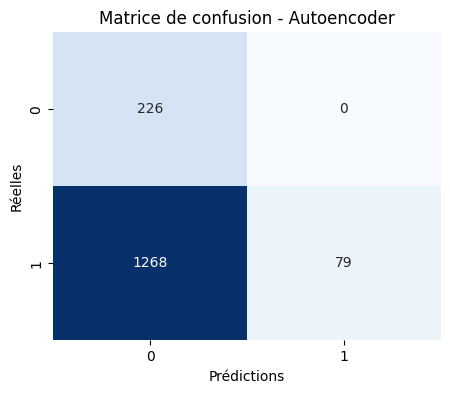


Classification Report - Autoencoder:
               precision    recall  f1-score   support

           0       0.15      1.00      0.26       226
           1       1.00      0.06      0.11      1347

    accuracy                           0.19      1573
   macro avg       0.58      0.53      0.19      1573
weighted avg       0.88      0.19      0.13      1573



In [8]:
plot_confusion_matrix(y_test, y_pred_knn, "KNN")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_svc, "SVM")
plot_confusion_matrix(y_test, y_pred_kmeans, "KMeans")

# Autoencoder → cas particulier (binaire défaut / normal)
plot_confusion_matrix((y_test != 0).astype(int), y_pred_auto, "Autoencoder")


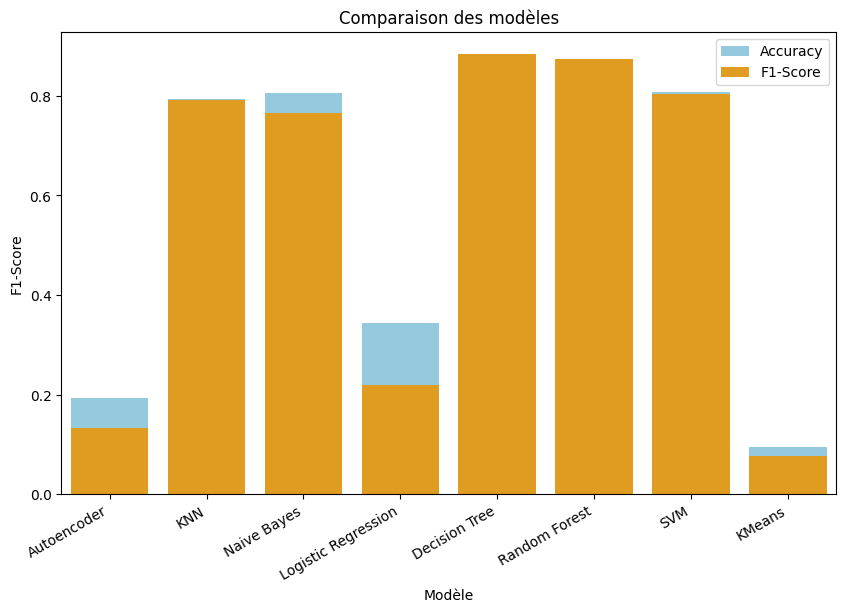

In [9]:
# =======================
# Graphe Comparatif
# =======================
plt.figure(figsize=(10,6))
sns.barplot(x="Modèle", y="Accuracy", data=df_results, color="skyblue", label="Accuracy")
sns.barplot(x="Modèle", y="F1-Score", data=df_results, color="orange", label="F1-Score")

plt.title("Comparaison des modèles")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.show()


In [17]:
import numpy as np
import joblib

# =============================
# 1. Chargement du modèle
# =============================

# Random Forest ou Decision Tree
rf_model = joblib.load("/kaggle/working/random_forest_model.pkl")
# Si tu veux utiliser Decision Tree à la place, fais : 
# from sklearn.tree import DecisionTreeClassifier
# dt_model = joblib.load("decision_tree_model.pkl")

# mapping des classes
fault_map = {
    0: "Pas de défaut",
    1: "Défaut type GA",
    2: "Défaut type GB",
    3: "Défaut type GC",
    4: "Défaut type ABC",
    # etc… adapte selon ton dataset
}

# =============================
# 2. Fonction de prédiction
# =============================
def predict_fault(values):
    """
    values : liste [Ia, Ib, Ic, Va, Vb, Vc]
    """
    X = np.array(values).reshape(1, -1)

    print("\n===== Prédiction =====")

    # ----- Random Forest -----
    pred = rf_model.predict(X)[0]
    print(f"Random Forest → {fault_map.get(pred, 'Classe inconnue')}")

# =============================
# 3. Interface utilisateur
# =============================
if __name__ == "__main__":
    print("=== Entrer les mesures électriques ===")
    Ia = float(input("Ia = "))
    Ib = float(input("Ib = "))
    Ic = float(input("Ic = "))
    Va = float(input("Va = "))
    Vb = float(input("Vb = "))
    Vc = float(input("Vc = "))

    values = [Ia, Ib, Ic, Va, Vb, Vc]
    predict_fault(values)


=== Entrer les mesures électriques ===


Ia =  6
Ib =  8
Ic =  3
Va =  3
Vb =  56
Vc =  8



===== Prédiction =====
Random Forest → Défaut type GA
